In [17]:
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage import io
from torch.utils.data import (
    Dataset,
    DataLoader,
)  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/Bangla Digit Recog/Dataset C.zip"

Streaming output truncated to the last 5000 lines.
  inflating: training-c/c19299.png   
  inflating: training-c/c19300.png   
  inflating: training-c/c19301.png   
  inflating: training-c/c19302.png   
  inflating: training-c/c19303.png   
  inflating: training-c/c19304.png   
  inflating: training-c/c19305.png   
  inflating: training-c/c19306.png   
  inflating: training-c/c19307.png   
  inflating: training-c/c19308.png   
  inflating: training-c/c19309.png   
  inflating: training-c/c19310.png   
  inflating: training-c/c19311.png   
  inflating: training-c/c19312.png   
  inflating: training-c/c19313.png   
  inflating: training-c/c19314.png   
  inflating: training-c/c19315.png   
  inflating: training-c/c19316.png   
  inflating: training-c/c19317.png   
  inflating: training-c/c19318.png   
  inflating: training-c/c19319.png   
  inflating: training-c/c19320.png   
  inflating: training-c/c19321.png   
  inflating: training-c/c19322.png   
  inflating: training-c/c19323.png   

In [ ]:
# load data

In [5]:
class BanglaDigitDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 3]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [6]:
data = BanglaDigitDataset("/content/training-c.csv","/content/training-c", transforms.Compose([transforms.ToPILImage(), transforms.Resize(size=(28, 28)), transforms.ToTensor()]))
train_set, test_set = torch.utils.data.random_split(data,[19438,4860])


In [7]:
# train_set[0][0].size()
data.__len__()

24298

In [8]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [9]:
# Hyperparameters
batch_size = 100
num_iters = 100000
input_dim = 28*28 # num_features = 784
num_hidden = 2000
output_dim = 10

learning_rate = 0.1
loss_lst = []
acc_lst = []

num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, 2048)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(2048, 1624)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(1624, 1248)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### 4th hidden layer: 100 --> 100
        self.linear_4 = nn.Linear(1248, 1024)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(1024, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        # x = x.view(x.shape[0], -1)
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_4(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)


# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            loss_lst.append(loss.item())
            acc_lst.append(accuracy)
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.3021857738494873. Accuracy: 9.40329218106996
Iteration: 1000. Loss: 2.29070782661438. Accuracy: 9.814814814814815
Iteration: 1500. Loss: 2.274613380432129. Accuracy: 12.489711934156379
Iteration: 2000. Loss: 2.2809319496154785. Accuracy: 9.320987654320987
Iteration: 2500. Loss: 2.3047735691070557. Accuracy: 17.40740740740741
Iteration: 3000. Loss: 2.279280185699463. Accuracy: 17.05761316872428
Iteration: 3500. Loss: 2.2668557167053223. Accuracy: 16.358024691358025
Iteration: 4000. Loss: 2.1724517345428467. Accuracy: 15.205761316872428
Iteration: 4500. Loss: 2.1800272464752197. Accuracy: 13.930041152263374
Iteration: 5000. Loss: 2.224336862564087. Accuracy: 17.51028806584362
Iteration: 5500. Loss: 2.189634323120117. Accuracy: 10.1440329218107
Iteration: 6000. Loss: 2.1640021800994873. Accuracy: 15.411522633744855
Iteration: 6500. Loss: 2.2730584144592285. Accuracy: 18.786008230452676
Iteration: 7000. Loss: 2.093755006790161. Accuracy: 21.85185185185185
Iteration:

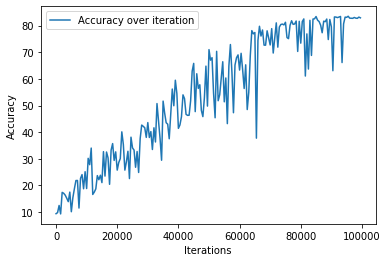

In [20]:
n_itr = np.arange(1,100000,500,int).tolist()
# len(n_itr)
plt.plot(n_itr,acc_lst,'-',label='Accuracy over iteration');
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

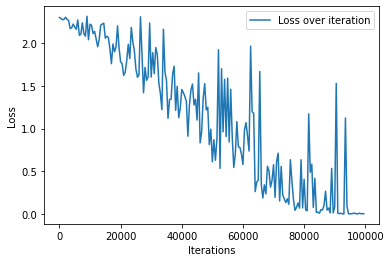

In [21]:
plt.plot(n_itr,loss_lst,'-',label='Loss over iteration');
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()